# Experimentación

En este notebook corremos los experimentos descritos en el informe

In [2]:
import subprocess

def run(algorithm: str, instance_path: str) -> (int, float):
    """Corre el programa para la instancia dada y devuelve (resultado, tiempo de ejecucion)."""
    result = subprocess.run(
        f"../build/npm {algorithm} < {instance_path}",
        shell=True, capture_output=True, text=True, check=True,
    )

    return int(result.stdout), float(result.stderr)

<AxesSubplot:>

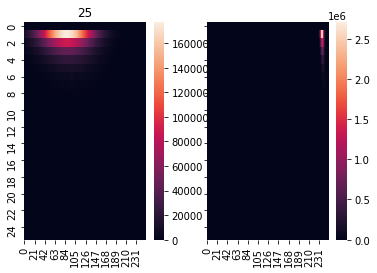

In [33]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_solapamiento(instance_path: str):
    """Corre el programa para la instancia dada y devuelve (resultado, matriz de solapamiento)."""
    result = subprocess.run(
        f"../build/npm GR < {instance_path}",
        shell=True, capture_output=True, text=True, check=True,
    )

    return json.loads(result.stderr.split('\n')[0])["pd_accesses"]

df1 = pd.DataFrame(run_solapamiento("instancias/grupos/1-grupos_1.in"))
df25 = pd.DataFrame(run_solapamiento("instancias/grupos/25-grupos_1.in"))

fig, ax = plt.subplots(ncols=2, sharey=True)
g = sns.heatmap(data=df25, cbar=True, ax=ax[0])
g.set_title("25")
sns.heatmap(data=df1, cbar=True, ax=ax[1])

In [5]:
from typing import List

def get_instances(dataset: str) -> List[str]:
    """Para cada dataset devuelve la lista de instancias correspondientes con el path completo"""
    instances = os.listdir(f"instancias/{dataset}")
    return list(filter(
        lambda i: i.endswith(".in"),
        map(lambda i: f"instancias/{dataset}/"+i, instances),
    ))


In [8]:
def run_instance(rows: list, dataset: str, algorithms: List[str]):
    """
    Corre una instancia para todos los algoritmos, llenando por referencia
    la lista de rows. Lanza una excepcion si para alguna instancia los
    resultados de todos los algoritmos no coinciden.
    """
    for instance in tqdm(get_instances(dataset), "instancias"):
        results = []
        for alg in algorithms:
            res, t = run(alg, instance)
            rows.append({
                "dataset": dataset,
                "algorithm": alg,
                "time_ms": t,
                "instance": instance,
            })

            results.append(res)

        if not np.alltrue([results[0] == res for res in results]):
            print(f"Ojo que con la instancia {instance} no dieron todos iguales")

## Experimento 1 - Control

In [7]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm

rows = []

datasets = [
    #"control", # Experimento 1 - Control
    #"grupos",   # Experimento 2 - Solapamiento por grupos
    #"identicos", # Experimento 3 - Todas instancias identicas
    "one-to-rule" # Experimento 4 - One tu rul dem ol
]

REPETICIONES = 10

for d in datasets:
    for _ in range(REPETICIONES):
        run_instance(rows, d)

df_results = pd.DataFrame(rows, columns=["dataset", "algorithm", "time_ms", "instance"])
print("Finished!")

instancias:   0%|          | 0/20 [00:00<?, ?it/s]


ValueError: could not convert string to float: ''

,dataset,algorithm,time_ms,instance,pos
0,one-to-rule,BT-O,51.2932,instancias/one-to-rule/2.in,
1,one-to-rule,BT-O,47.3113,instancias/one-to-rule/pos_16.in,16
2,one-to-rule,BT-O,47.3158,instancias/one-to-rule/3.in,
3,one-to-rule,BT-O,43.5779,instancias/one-to-rule/14.in,n
4,one-to-rule,BT-O,45.4797,instancias/one-to-rule/pos_13.in,13


<AxesSubplot:xlabel='algorithm', ylabel='time_ms'>

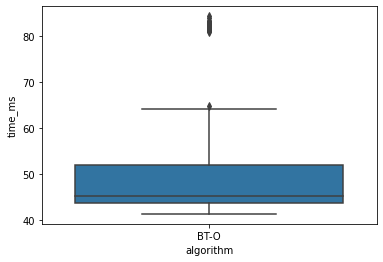

In [23]:
import seaborn as sns

sns.boxplot(data=df_results, y="time_ms", x="algorithm")

In [29]:
# instancias/grupos/6-grupos_1.in
#df_results["grupo"] = df_results["instance"].map(lambda r: r.split("/")[2][0])
# instancias/one-to-rule/pos_i.in
df_results["pos"] = df_results["instance"].map(lambda r: int(r.split("/")[2][4:].split('.')[0]))

In [30]:
df_results

,dataset,algorithm,time_ms,instance,pos
0,one-to-rule,BT-O,47.5266,instancias/one-to-rule/pos_16.in,16
1,one-to-rule,BT-O,44.6092,instancias/one-to-rule/pos_13.in,13
2,one-to-rule,BT-O,54.7605,instancias/one-to-rule/pos_17.in,17
3,one-to-rule,BT-O,43.1216,instancias/one-to-rule/pos_10.in,10
4,one-to-rule,BT-O,43.6970,instancias/one-to-rule/pos_11.in,11
...,...,...,...,...,...
195,one-to-rule,BT-O,53.7698,instancias/one-to-rule/pos_1.in,1
196,one-to-rule,BT-O,46.6934,instancias/one-to-rule/pos_3.in,3
197,one-to-rule,BT-O,53.4060,instancias/one-to-rule/pos_0.in,0
198,one-to-rule,BT-O,83.1587,instancias/one-to-rule/pos_19.in,19


<AxesSubplot:xlabel='grupo', ylabel='time_ms'>

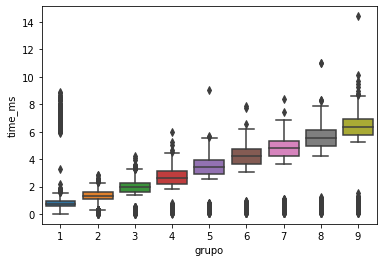

In [59]:
sns.boxplot(data=df_results.sort_values("grupo"), x="grupo", y="time_ms")

<AxesSubplot:xlabel='pos', ylabel='time_ms'>

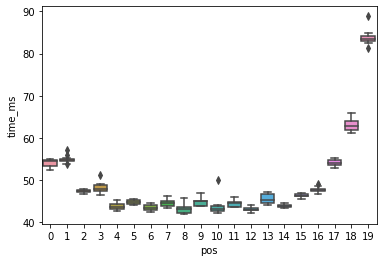

In [31]:
sns.boxplot(data=df_results.sort_values("pos"), x="pos", y="time_ms")
# tiene sentido que el ultimo tarde mas porque recorre primero todo, y despues chequea la opt, que es lo mismo que NADA

## Implementación de la experimentación

In [2]:
ALL = ["FB", "BT", "BT-F", "BT-O", "DP"]

In [3]:
# type experimento struct {
#     algoritmos: []string
#     dataset: string
# }

experimentos = [
    {
        "algoritmos" : ALL,
        "dataset"    : "control",
    },
    {
        "algoritmos" : ["BT", "DP"], # DP para ver cómo afecta el solapamiento y BT debería ser siempre más o menos igual
        "dataset"    : "grupos",
    },
    {
        "algoritmos" : ALL,
        "dataset"    : "one-to-rule",
    },
    {
        "algoritmos" : ALL,
        "dataset"    : "identicos",
    },
    {
        "algoritmos" : ["BT-F", "DP"],
        "dataset"    : "low-M",
    },
    {
        "algoritmos" : ["BT-F", "DP"],
        "dataset"    : "cache",
    },
    {
        "algoritmos" : ALL,
        "dataset"    : "n-variable",
    }
]


In [ ]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm

rows = []

for i, experimento in enumerate(experimentos):
    print("Corriendo el experimento {0} ({1}/{2})".format(experimento["dataset"], i+1, len(experimentos)))
    run_instance(rows, experimento["dataset"], experimento["algoritmos"])

df_results = pd.DataFrame(rows, columns=["dataset", "algorithm", "time_ms", "instance"])
print("Finished!")


instancias:   0%|          | 0/10 [00:00<?, ?it/s]

Corriendo el experimento control (1/7)



instancias:   0%|          | 0/1000 [00:00<?, ?it/s]

Corriendo el experimento grupos (2/7)


instancias:   9%|▉         | 93/1000 [03:31<33:16,  2.20s/it]

Ojo que con la instancia instancias/grupos/2-grupos_9.in no dieron todos iguales


instancias:  34%|███▍      | 339/1000 [12:28<18:42,  1.70s/it]

Ojo que con la instancia instancias/grupos/1-grupos_8.in no dieron todos iguales


instancias:  40%|████      | 402/1000 [14:36<18:11,  1.82s/it]

Ojo que con la instancia instancias/grupos/1-grupos_9.in no dieron todos iguales


instancias:  67%|██████▋   | 672/1000 [24:21<11:30,  2.11s/it]

In [ ]:
df_results.to_csv("resultados.csv")